In [1]:
import tf_keras as tfk
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
import cv2

from tensorflow import image as tfi
from tensorflow import data as tfd
from gradio_client import Client
from tf_keras.preprocessing.image import load_img, img_to_array
from tf_keras.applications.imagenet_utils import preprocess_input

c:\Users\akmal\miniconda3\envs\semifinal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def clean_text(text):
    text = text.replace("*", "")
    text = text.replace("#", "")
    text = text.replace("```", "")
    text = text.replace("_", "")
    text = text.rstrip()
    text = " ".join(text.split())
    return text

In [3]:
def qwen2(message):
    # client = Client("Qwen/Qwen2-72B-Instruct")
    client = Client("Qwen/Qwen2-57b-a14b-instruct-demo")
    result = client.predict(
        query=message,
        history=[],
        system=f"Buatlah dalam 1 paragraf. Jelaskan mengenai jenis fitoplankton {message}",
        api_name="/model_chat"
    )
    return result[1][0][1]

In [4]:
def gemma2(message):
    client = Client("huggingface-projects/gemma-2-9b-it")
    result = client.predict(
        message=f'Buatlah dalam 1 paragraf. Jelaskan mengenai jenis fitoplankton {message}',
        max_new_tokens=1024,
        temperature=0.6,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.2,
        api_name="/chat"
    )
    return result




1/1 [==============================] - 2s 2s/step


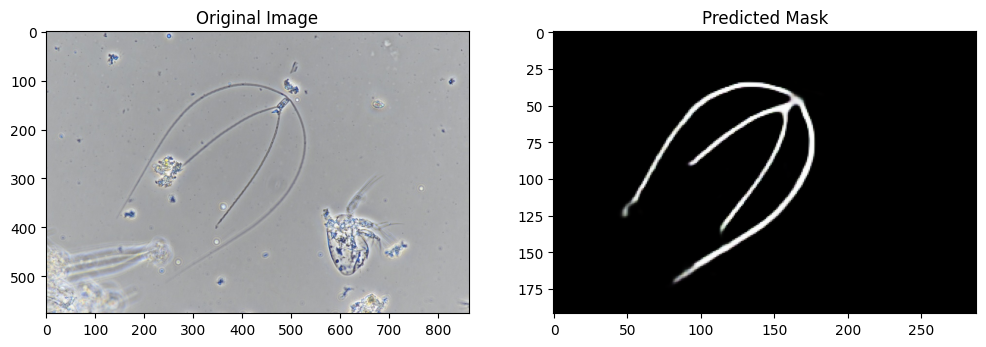

In [5]:
def load_image_for_prediction(path, IMAGE_SIZE=(192, 288)):
    image = load_img(path)
    image = img_to_array(image)
    image = tfi.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

def predict_mask(model, image_path, IMAGE_SIZE=(192, 288)):
    image = load_image_for_prediction(image_path, IMAGE_SIZE=IMAGE_SIZE)
    predicted_mask = model.predict(image[np.newaxis, ...])[0]
    return predicted_mask

def input_image(img_path, l_model):
    actual_image = np.asarray(load_img(img_path))
    predicted_mask = predict_mask(l_model, img_path)
    cv2.imwrite('../static/uploads/original_image.jpg', cv2.cvtColor(actual_image, cv2.COLOR_RGB2BGR))
    cv2.imwrite('../static/uploads/predicted_mask.jpg', predicted_mask * 255)
    return actual_image, predicted_mask
    
def visualize_prediction(original_image, predicted_mask):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()

actual_image, predicted_mask = input_image("../dataset/base/image/Chaetoceros peruvianus/Chaetoceros peruvianus 1_horizontal.jpg", tfk.models.load_model("../model/segmentation/deeplab_segmentation_plankton"))
visualize_prediction(actual_image, predicted_mask)

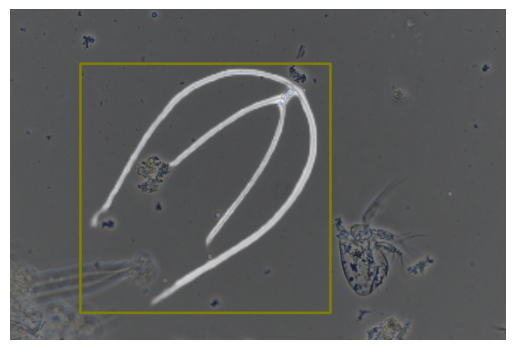

In [6]:
def detect_and_save_contours(img_path: str, mask_path: str, output_path: str):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)
    
    img = cv2.resize(img, (1728, 1152))
    mask = cv2.resize(mask, (1728, 1152))
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = None
    largest_area = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area > largest_area:
            largest_area = area
            largest_contour = contour
    
    if largest_contour is not None:
        x, y, w, h = cv2.boundingRect(largest_contour)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 7)
    
    mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    alpha = 0.5
    combined_img = cv2.addWeighted(img, 1 - alpha, mask_colored, alpha, 0)
    
    cv2.imwrite(output_path, combined_img)
    
    img_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    return x, y, w, h

img_image = '../static/uploads/original_image.jpg'
mask_image = '../static/uploads/predicted_mask.jpg'
output_image = '../static/uploads/output_image.jpg' 

x, y, w, h = detect_and_save_contours(img_image, mask_image, output_image)

In [7]:
def display_roi_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = None
    largest_area = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area > largest_area:
            largest_area = area
            largest_contour = contour
    
    if largest_contour is not None:
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        return (x, y, w, h)
    else:
        print("Tidak ada kontur yang ditemukan.")
        return None

def return_roi_image():
    img_image = cv2.imread('../static/uploads/original_image.jpg')
    mask_image = cv2.imread('../static/uploads/predicted_mask.jpg')
    img = cv2.resize(img_image, (1728, 1152))
    mask = cv2.resize(mask_image, (1728, 1152))

    x, y, w, h = display_roi_image(mask)

    roi = img[y:y+h, x:x+w]
    roi = cv2.resize(roi, (224, 224))
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    return roi, (x, y, w, h)

def implement_roi_image(img_path):
    input_image(img_path, tfk.models.load_model('../model/segmentation/deeplab_segmentation_plankton'))
    roi, (x, y, w, h) = return_roi_image()
    return roi, (x, y, w, h)

In [8]:
def img_array(img_array):
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array, mode='tf', data_format=None)
    return img_array

def predict_img(model_option, llm_option, img_path):
    if model_option == "vit":
        model = tfk.models.load_model('../model/classification/vit_model_plankton')
    elif model_option == "bit":
        model = tfk.models.load_model('../model/classification/bit_model_plankton')
    elif model_option == "conv":
        model = tfk.models.load_model('../model/classification/conv_model_plankton')
    elif model_option == "regnet":
        model = tfk.models.load_model('../model/classification/regnet_model_plankton')
    elif model_option == "swin":
        model = tfk.models.load_model('../model/classification/swin_model_plankton')
    else:
        model = "Pilih model yang sesuai."

    with open('../model/labels.json', 'r') as label_file:
        class_names = json.load(label_file)
        
    predictions = model.predict(img_array(img_path))
    
    actual_class = [class_names[str(i)] for i in np.argsort(predictions[0])[-3:][::-1]]
    probability_class = np.sort(predictions[0])[-3:][::-1].tolist()
    
    if llm_option == "qwen":
        response = clean_text(qwen2(actual_class[0]))
    elif llm_option == "gemma":
        response = clean_text(gemma2(actual_class[0]))
    else:
        response = "Pilih model LLM yang sesuai."
    
    return actual_class, probability_class, response

1/1 [==============================] - 32s 32s/step
Loaded as API: https://qwen-qwen2-57b-a14b-instruct-demo.hf.space ✔
Actual Class: ['Achnanthes sp', 'Guinardia flaccida', 'Proboscia indica']
Probability: [0.9985193610191345, 0.0005636180867440999, 0.000549710588529706]
Response: Achnanthes sp adalah jenis fitoplankton yang termasuk dalam kelas Bacillariophyceae, yaitu bagian dari filum diatom. Diatom ini memiliki ciri khas dengan struktur silika yang unik dan kompleks, yang biasanya berbentuk seperti tabung atau kerucut. Achnanthes sp juga dikenal karena kemampuan mereka untuk tumbuh dan berkembang biak secara cepat, menjadikannya sebagai komponen penting dalam ekosistem air tawar dan laut. Selain itu, Achnanthes sp juga merupakan sumber makanan bagi banyak jenis ikan dan krill, sehingga memainkan peran penting dalam rantai makanan laut.


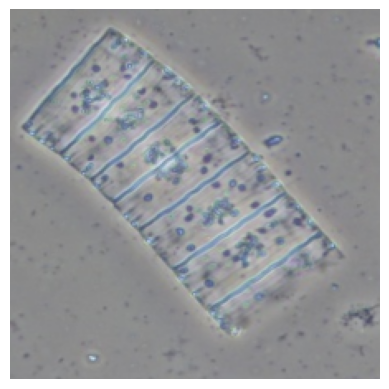

In [9]:
img_path = "../dataset/base/image/Achnanthes sp/Achnanthes sp 2.jpg"

roi, (x, y, w, h) = implement_roi_image(img_path)
model_option = "vit"
llm_option = "qwen"
actual_class, probability_class, response = predict_img(model_option, llm_option, roi)

print(f"Actual Class: {actual_class}")
print(f"Probability: {probability_class}")
print(f"Response: {response}")

(-0.5, 1727.5, 1151.5, -0.5)

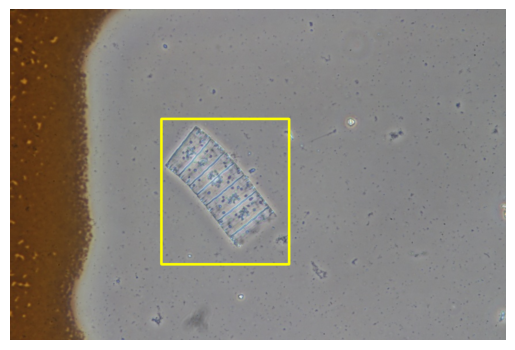

In [10]:
original_image = cv2.imread(img_path)
resized_image = cv2.resize(original_image, (1728, 1152))

roi, (x, y, w, h) = return_roi_image()

contour_image = resized_image.copy()
cv2.rectangle(contour_image, (x, y), (x + w, y + h), (0, 255, 255), 7)
contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

plt.imshow(contour_image_rgb)
plt.axis('off')